In [ ]:
%matplotlib inline
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

In [ ]:
# Note : this will generate two deprecation warnings when creating the pulse_blaster
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(500)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster

lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')

microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
microwave_src.output('OFF')
microwave_src.output_level_unit('dBm')
microwave_src.IQ_modulation('EXT')
# Note : this will generate the following errors that can be ignored
#     [pulse_blaster(PulseBlasterESRPRO)] Error getting or interpreting *IDN?: ''
#     [lock_in_amp(SR830)] Snapshot: Could not update parameter: output_interface
#     [microwave_src(MG3681A)] Snapshot: Could not update parameter: output
#     [microwave_src(MG3681A)] Snapshot: Could not update parameter: output_level_unit
#     [microwave_src(MG3681A)] Snapshot: Could not update parameter: pulse_modulation
#

dc_supply = korad.KD3305P('dc_supply', 'ASRL6::INSTR')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

pulse_blaster.stop()

## Preperation Work
The aim of all the lab 3 components is to study various pulse sequences related to probing the spin dynamics of the NV center and extending its coherence time. Before we can do that, we must find the resonance frequency of our system. To do this, use the ODMR template developed in lab 2 with a magnetic field of ~4mT. Note that you can use your coil constant value to determine the required current for a 4mT field.

In [ ]:
dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(#Your Current Setpoint Here)

microwave_src.frequency(#Determined Resonance Frequency Here)
microwave_src.power(#Your Microwave Power Here)

Next, we need the $\pi/2$ and $\pi$ pulselengths for both the X and Y rotation gates. This is done by observing the frequency of Rabi oscillations when oscillating about the respective axis. For the X-axis, we already set this up last week. Use the template developed in lab 2 for Rabi oscillations to determine the pulselengths for $\pi$ and $\pi/2$ X rotation gates.

In [ ]:
T_X_pi = #Enter the pi rotation pulselength for the I-channel here.
T_X_pi_2 = T_X_pi / 2

Now we want to get rotations about the Y-axis. How can we do this with our system? Let’s suppose that all our pulses have been $R_x(\theta)$ operations. Changing the phase of the microwave pulses by 90◦ will result in rotations about the y-axis; $R_y(\theta)$. We will still use the same microwave source as before, but now introduce another input, given by Channel 3 of the pulse blaster. Together with the input from Channel 2, we will be performing IQ-modulation of the microwave carrier wave.

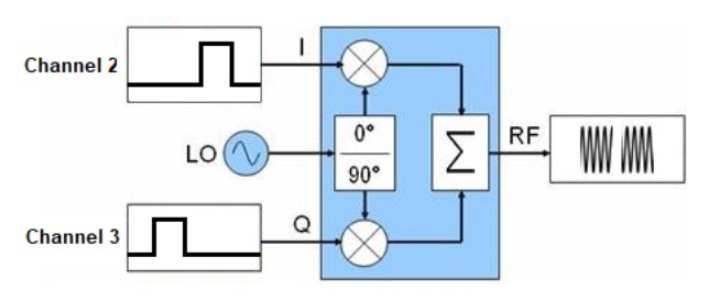

The local oscillator (’LO’) is a continuously running oscillator; its phase never changes. We have two independent signals (labelled Channel 2 and Channel 3 in Figure 1) that are the ’I’ and ’Q’ inputs to the IQ modulator. The ’I’ input amplitude-modulates the local oscillator. The ’Q’ input amplitude-modulates a copy of the ’LO’ with a 90-degree phase difference. These two amplitude modulated signals are inputs to a hardware summing junction, and the final sum is delivered to the antenna.

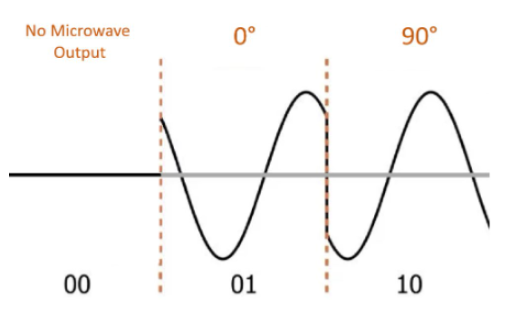

The power output from the I and Q channels may not be the same, and therefore the time taken to rotate the spins from $|0\rangle$ to $|-1\rangle$ using the Q channel ($T_{Y_\pi}$) may not be the same. Modify the code in Task 3.0.1 to measure Rabi oscillations using the Q channel i.e. Channel 3 of the PulseBlaster and then enter $T_{Y_\pi}$ (to the nearest 100 ns) below.

In [ ]:
T_Y_pi = #Enter the pi rotation pulselength for the Q-channel here.
T_Y_pi_2 = T_Y_pi / 2

With these components, we now have all the tools needed to run coherent control experiments with this setup. For the rest of the templates in this lab, be sure to use the same parameters you determined found above.

## Ramsey Fringes XX

Now that we have measured these experimental parameters we can now begin the lab in proper. The first task is to measure the dephasing time $T_2^*$, which is done so by measuring the decay time of Ramsey fringes.

We can measure Ramsey fringes by applying the following gates:

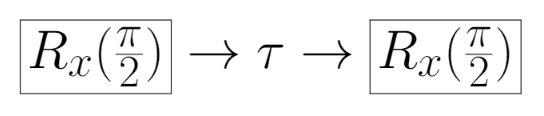

or in other words, the pulse sequence:

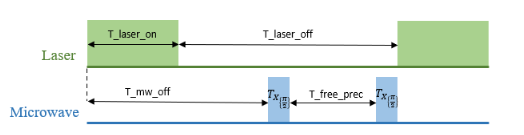

Program the PulseBlaster to perform a Ramsey fringes experiment below.

In [ ]:
#Use this to make a parameter out of anything!
FPT = qc.Parameter("Precession", unit = 's')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "Rabi Fringes.db")
experiment = load_or_create_experiment(
    experiment_name='Rabi Fringes',
    sample_name=""
)
meas = Measurement(exp=experiment, name='Rabi Fringes')
meas.register_parameter(FPT)  # register the first independent parameter
meas.register_parameter(LI_R) # now register the dependent one

In [ ]:
ref_f =                                     #Reference frequency.
ref_D =                                     #Reference duty cycle.
T_ref_on = ref_D/ref_f                         #Reference time on.
T_ref_off = (1 - ref_D)/ref_f                  #Reference time off.

laser_f =                                      #Laser modulation frequency.
laser_D =                                      #Laser modulation duty cycle.
T_laser_on =                                   #Laser time on. 
T_laser_off =                                  #Laser time off.
N_laser_pulses =                               #Number of laser pulses that can fit in the reference period.

ramsey_f =                                     #Ramsey repition rate
N_ramsey =                                     #Number of Ramsey measurements within one period of the reference frequency
T_free_prec_0 = 1e-6                           #The free precession time i.e. tau - the time between the two X_pi gates.
T_padding =     

def T_mw_off(t_free_prec):
    return #Your code for determining ho long to leave the microwave signal off for here


def Ramsey_Fringe_PP(t_free_prec):
    #TODO: Fill out the pulse sequences below.
    pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        #TODO: Enter the lock-in reference pulse sequence.
    )                                            
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        #TODO: Enter the laser pulse sequence.
    )                                           
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        #TODO: Enter the 'I' microwave modulation pulse sequence.
    )

Ramsey_Fringe_PP(T_free_prec_0)
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.

In [ ]:
lock_in_amp.time_constant(#Your time constant here)
lock_in_amp.sensitivity(# Your sensitivity here)

#Set your start/finish times and the step size.
fpt_s =                                #Your start free precession time here
fpt_f =                                #Your end free precession time here
step_fpt =                             #Your Free precession time step size

In [ ]:
microwave_src.output('ON')
with meas.run() as datasaver:
    ##########################
    #Your experiment code here
        
    ##########################
    Rabi_Fringe_data = datasaver.dataset  # convenient to have for data access and plotting

Rabi_Fringe = Rabi_Fringe_data.to_pandas_dataframe()
plt.plot(Rabi_Fringe["Precession"], Rabi_Fringe["Signal"])
plt.xlabel('Free Procession Time (s)')
plt.ylabel('Signal(V)')
plt.title(f'Rabi Fringes')
plt.show()
pulse_blaster.stop()

## Ramsey Fringes XY

In [ ]:
#Use this to make a parameter out of anything!
FPT = qc.Parameter("Precession", unit = 's')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "Ramsey Fringes XY.db")
experiment = load_or_create_experiment(
    experiment_name='Ramsey Fringes XY',
    sample_name=""
)

meas = Measurement(exp=experiment, name='Ramsey Fringes XY')
meas.register_parameter(FPT)  # register the first independent parameter
meas.register_parameter(LI_R) # now register the dependent oone

In [ ]:
ref_f =                                      #Reference frequency.
ref_D =                                      #Reference duty cycle.
T_ref_on = ref_D/ref_f                       #Reference time on.
T_ref_off = (1 - ref_D)/ref_f                #Reference time off.

laser_f =                                    #Laser modulation frequency.
laser_D =                                    #Laser modulation duty cycle.
T_laser_on =                                 #Laser time on. 
T_laser_off =                                #Laser time off.
N_laser_pulses = r                           #Number of laser pulses that can fit in the reference period.

ramsey_f =                                   #Ramsey repition rate
N_ramsey =                                   #Number of Ramsey measurements within one period of the reference frequency
                                             #The free precession time i.e. tau - the time between the two X_pi gates.
def T_mw_off(t_free_prec):
    return #Your microwave off control code here

T_free_prec_0 = 1e-6
T_padding = 2e-9
def Ramsey_Fringe_PP(t_free_prec):
    #TODO: Fill out the pulse sequences below.
    pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        #TODO: Enter the lock-in reference pulse sequence.
    )                                            
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        #TODO: Enter the laser pulse sequence.
    )                                           
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        #TODO: Enter the 'I' microwave modulation pulse sequence.
    )    
Ramsey_Fringe_PP(T_free_prec_0)
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.

In [ ]:
lock_in_amp.time_constant(#Your time constant here)
lock_in_amp.sensitivity(#Your sensitivity here)

#Set your start/finish times and the step size.
fpt_s = 
fpt_f = 
step_fpt = 

In [ ]:
microwave_src.output('ON')
with meas.run() as datasaver:
    ##########################
    #Your experiment code here
        
    ##########################
    Rabi_Fringe_data = datasaver.dataset  # convenient to have for data access and plotting

#### Q1. Comment on the feature of your Ramsey experiments. In particular, comment on the direction of the decays, and the frequency of the oscillations.

A parameter of interest is the $T_2^*$, which can be extrated by fitting the measured data to the appropriate theoretical model. In previous labs, we have demonstrated how to fit a curve using python. In your own time, using python or another software package (e.g. MatLab, OriginPro, etc.) fit the data to the appropriate model and extract the $T_2^*$ time. 

**You must show the fitted curve, the fit model and $T_2^*$ in your lab report.**